In [86]:
import pandas as pd

url = "https://raw.githubusercontent.com/Rishabh1108ch/JP_Morgan_Quantitative_Research/main/Task4%3A-FICO_score_quantization-%26-default_prediction/Task%203%20and%204_Loan_Data.csv"
df = pd.read_csv(url)
display(df.head())

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [87]:
from ipywidgets import interactive, Dropdown, FloatText, IntText, Button, Output, VBox
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define NEW predefined customer data with diverse FICO scores
predefined_customers = {
    "Select a customer": None,
    "D. Trump": {
        'credit_lines_outstanding': 5,
        'loan_amt_outstanding': 100000.0,
        'total_debt_outstanding': 500000.0,
        'income': 1000000.0,
        'years_employed': 20,
        'fico_score': 450 # Changed FICO score
    },
    "Modi": {
        'credit_lines_outstanding': 2,
        'loan_amt_outstanding': 10000.0,
        'total_debt_outstanding': 30000.0,
        'income': 150000.0,
        'years_employed': 15,
        'fico_score': 600 # Changed FICO score
    },
    "Putin": {
        'credit_lines_outstanding': 8,
        'loan_amt_outstanding': 50000.0,
        'total_debt_outstanding': 200000.0,
        'income': 200000.0,
        'years_employed': 25,
        'fico_score': 780 # Changed FICO score
    }
}

# Add an option to analyze all predefined customers
predefined_customers_with_all = predefined_customers.copy()
predefined_customers_with_all["Analyze all predefined customers"] = "all"

# Create input widgets
customer_dropdown = Dropdown(options=predefined_customers_with_all.keys(), description='Select Customer:')
credit_lines_widget = IntText(description='Credit Lines:', disabled=True)
loan_amt_widget = FloatText(description='Loan Amt:', disabled=True)
total_debt_widget = FloatText(description='Total Debt:', disabled=True)
income_widget = FloatText(description='Income:', disabled=True)
years_employed_widget = IntText(description='Years Employed:', disabled=True)
fico_score_widget = IntText(description='FICO Score:', disabled=True)

predict_button = Button(description='Predict')
output_area = Output()

# Function to update input fields or trigger analysis based on selection
def update_interface(change):
    selected_option = change['new']
    if selected_option == "Analyze all predefined customers":
        # Disable individual input fields
        credit_lines_widget.disabled = True
        loan_amt_widget.disabled = True
        total_debt_widget.disabled = True
        income_widget.disabled = True
        years_employed_widget.disabled = True
        fico_score_widget.disabled = True
        predict_button.disabled = False # Enable predict button for analysis
    elif predefined_customers[selected_option] is not None:
        # Enable individual input fields and populate with selected customer data
        credit_lines_widget.disabled = False
        loan_amt_widget.disabled = False
        total_debt_widget.disabled = False
        income_widget.disabled = False
        years_employed_widget.disabled = False
        fico_score_widget.disabled = False
        predict_button.disabled = False

        selected_customer = predefined_customers[selected_option]
        credit_lines_widget.value = selected_customer['credit_lines_outstanding']
        loan_amt_widget.value = selected_customer['loan_amt_outstanding']
        total_debt_widget.value = selected_customer['total_debt_outstanding']
        income_widget.value = selected_customer['income']
        years_employed_widget.value = selected_customer['years_employed']
        fico_score_widget.value = selected_customer['fico_score']
    else:
        # Clear fields and disable for "Select a customer"
        credit_lines_widget.disabled = True
        loan_amt_widget.disabled = True
        total_debt_widget.disabled = True
        income_widget.disabled = True
        years_employed_widget.disabled = True
        fico_score_widget.disabled = True
        predict_button.disabled = True
        credit_lines_widget.value = 0
        loan_amt_widget.value = 0.0
        total_debt_widget.value = 0.0
        income_widget.value = 0.0
        years_employed_widget.value = 0
        fico_score_widget.value = 0


customer_dropdown.observe(update_interface, names='value')

# Function to handle prediction when the button is clicked
def on_predict_button_clicked(b):
    with output_area:
        clear_output()
        try:
            selected_option = customer_dropdown.value

            if selected_option == "Analyze all predefined customers":
                print("--- Analyzing All Predefined Customers ---")
                comparison_data = []
                for name, data in predefined_customers.items():
                    if data is not None and name != "Select a customer":
                        predicted_prob, fico_rating = predict_default_probability(
                            data,
                            optimal_boundaries,
                            rating_map_optimized,
                            ct,
                            scaler,
                            model
                        )
                        # Determine binary prediction
                        binary_prediction = 1 if predicted_prob > 0.5 else 0
                        prediction_label = "Default (1)" if binary_prediction == 1 else "Non-Default (0)"

                        comparison_data.append({
                            'Customer': name,
                            'FICO Score': data['fico_score'],
                            'Quantized Rating': fico_rating,
                            'Predicted Probability of Default': predicted_prob,
                            'Prediction (0: Non-Default, 1: Default)': binary_prediction, # Include binary prediction
                            'Prediction Label': prediction_label # Include prediction label
                        })

                comparison_df = pd.DataFrame(comparison_data)
                # Display results in a table
                display(comparison_df[['Customer', 'FICO Score', 'Quantized Rating', 'Predicted Probability of Default', 'Prediction (0: Non-Default, 1: Default)', 'Prediction Label']])


                # Visualize the comparison including FICO and rating
                plt.figure(figsize=(12, 7))
                # Using Prediction Label for hue
                ax = sns.barplot(x='Customer', y='Predicted Probability of Default', hue='Prediction Label', data=comparison_df, palette='viridis') # Palette changed for distinction
                plt.title('Comparison of Predicted Default Probability for Predefined Customers')
                plt.ylabel('Predicted Probability of Default')
                plt.ylim(0, 1)

                # Add labels inside bars (FICO Score and Quantized Rating)
                for container in ax.containers:
                  # Get the data for the current hue level
                  hue_data = comparison_df[comparison_df['Prediction Label'] == container.get_label()]
                  # Ensure labels match the order of bars in the container
                  labels = [f"FICO: {row['FICO Score']}\nRating: {row['Quantized Rating']}" for index, row in hue_data.iterrows()]
                  ax.bar_label(container, labels=labels, label_type='center', color='black', fontsize=9)


                plt.show()


            elif predefined_customers[selected_option] is not None:
                # Handle single customer prediction (existing logic)
                 customer_data_input = {
                    'credit_lines_outstanding': credit_lines_widget.value,
                    'loan_amt_outstanding': loan_amt_widget.value,
                    'total_debt_outstanding': total_debt_widget.value,
                    'income': income_widget.value,
                    'years_employed': years_employed_widget.value,
                    'fico_score': fico_score_widget.value
                }

                 predicted_prob, fico_rating = predict_default_probability(
                    customer_data_input,
                    optimal_boundaries,
                    rating_map_optimized,
                    ct,
                    scaler,
                    model
                )

                 print(f"--- Prediction Results for {selected_option} ---")
                 print(f"Input FICO Score: {customer_data_input['fico_score']}")
                 print(f"Quantized FICO Rating: {fico_rating}")
                 print(f"Predicted Probability of Default: {predicted_prob:.4f}")
                 if predicted_prob > 0.5: # Example threshold for binary prediction
                      print("Prediction: Likely to Default")
                 else:
                      print("Prediction: Unlikely to Default")


        except NameError as e:
             print(f"\nError: {e}. Please ensure 'optimal_boundaries', 'rating_map_optimized', 'ct', 'scaler', and 'model' are defined by running the previous cells.")
        except Exception as e:
             print(f"\nAn error occurred during prediction: {e}")


predict_button.on_click(on_predict_button_clicked)

# Arrange widgets vertically
interface_layout = VBox([
    customer_dropdown,
    credit_lines_widget,
    loan_amt_widget,
    total_debt_widget,
    income_widget,
    years_employed_widget,
    fico_score_widget,
    predict_button,
    output_area
])

print("Use the interface below to predict default probability:")
display(interface_layout)

Use the interface below to predict default probability:


In [88]:
# Check data types
print("Data types:")
display(df.dtypes)

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

Data types:


,0
customer_id,int64
credit_lines_outstanding,int64
loan_amt_outstanding,float64
total_debt_outstanding,float64
income,float64
years_employed,int64
fico_score,int64
default,int64



Missing values:


,0
customer_id,0
credit_lines_outstanding,0
loan_amt_outstanding,0
total_debt_outstanding,0
income,0
years_employed,0
fico_score,0
default,0


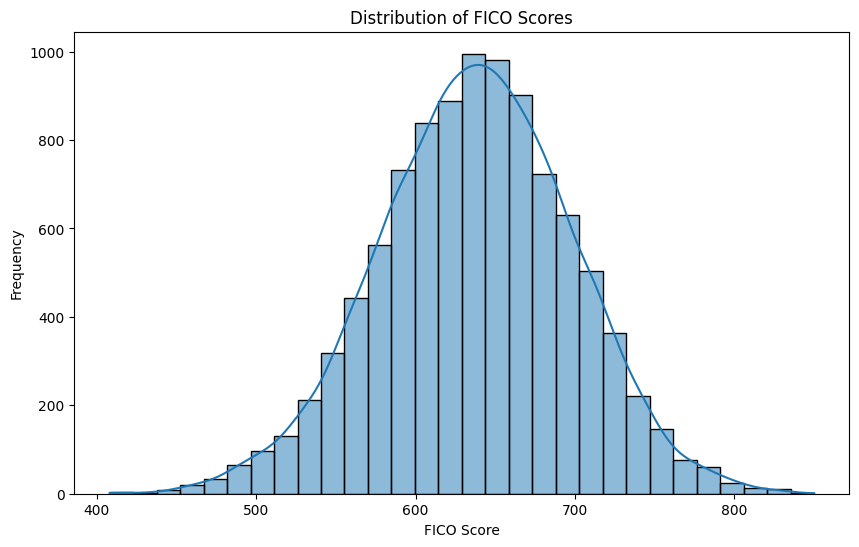

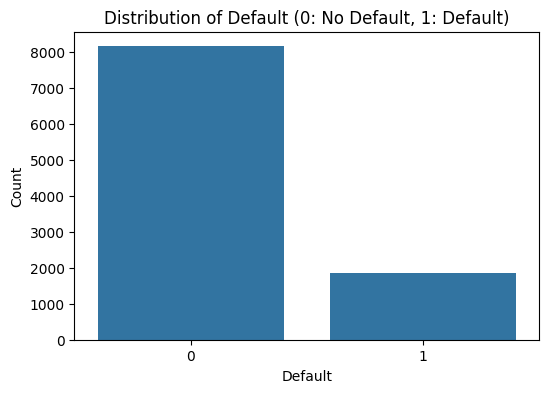

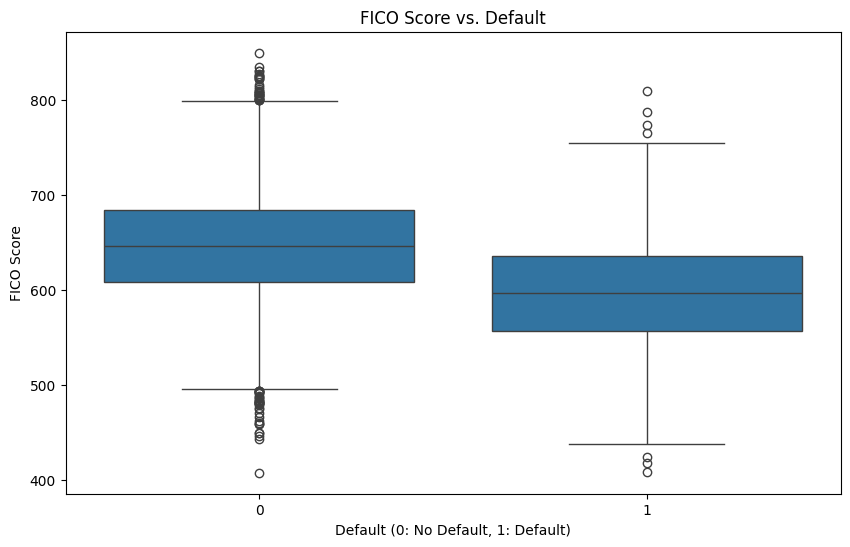

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of FICO scores
plt.figure(figsize=(10, 6))
sns.histplot(df['fico_score'], bins=30, kde=True)
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

# Distribution of default
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=df)
plt.title('Distribution of Default (0: No Default, 1: Default)')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

# Relationship between FICO score and default
plt.figure(figsize=(10, 6))
sns.boxplot(x='default', y='fico_score', data=df)
plt.title('FICO Score vs. Default')
plt.xlabel('Default (0: No Default, 1: Default)')
plt.ylabel('FICO Score')
plt.show()

##  quantization strategy




In [91]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sort the DataFrame by FICO score
df_sorted = df.sort_values(by='fico_score').reset_index(drop=True)

# Define the log-likelihood function to minimize
def log_likelihood(boundaries, fico_scores, defaults):
    """
    Calculates the negative log-likelihood for given boundaries.
    Assumes boundaries are sorted and cover the range of fico_scores.
    """
    n_buckets = len(boundaries) - 1
    ll = 0
    for i in range(n_buckets):
        # Select data within the current bucket
        if i == 0:
            mask = (fico_scores >= boundaries[i]) & (fico_scores <= boundaries[i+1])
        else:
            mask = (fico_scores > boundaries[i]) & (fico_scores <= boundaries[i+1])

        bucket_defaults = defaults[mask]
        n_total = len(bucket_defaults)
        n_defaults = bucket_defaults.sum()

        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-10
        p = (n_defaults + epsilon) / (n_total + 2 * epsilon) # Additive smoothing

        # Log-likelihood contribution of the bucket
        if n_total > 0:
             ll += n_defaults * np.log(p) + (n_total - n_defaults) * np.log(1 - p)

    # We want to maximize the log-likelihood, so we return the negative
    return -ll

# Initial guess for boundaries (equally spaced percentiles)
n_buckets = 5
initial_boundaries = np.percentile(df_sorted['fico_score'], np.linspace(0, 100, n_buckets + 1))

# Ensure boundaries are unique and sorted
initial_boundaries = np.unique(initial_boundaries)
# Adjust if initial guess doesn't yield enough unique boundaries
while len(initial_boundaries) < n_buckets + 1:
    # Add more points to the linspace or use a different method for initial guess
    # For simplicity, let's refine the linspace or add small perturbations
    initial_boundaries = np.percentile(df_sorted['fico_score'], np.linspace(0, 100, len(initial_boundaries) * 2))
    initial_boundaries = np.unique(initial_boundaries)
    if len(initial_boundaries) > n_buckets + 1:
        initial_boundaries = np.percentile(df_sorted['fico_score'], np.linspace(0, 100, n_buckets + 1))
        initial_boundaries = np.unique(initial_boundaries)
        break


# Define constraints: boundaries must be sorted and within the range of FICO scores
constraints = ({'type': 'ineq', 'fun': lambda x: np.diff(x)}) # ensure boundaries are increasing

# Define bounds for each boundary (within the range of FICO scores)
bounds = [(df_sorted['fico_score'].min(), df_sorted['fico_score'].max()) for _ in range(n_buckets + 1)]
# The first boundary should be the minimum FICO score and the last should be the maximum
bounds[0] = (df_sorted['fico_score'].min(), df_sorted['fico_score'].min())
bounds[-1] = (df_sorted['fico_score'].max(), df_sorted['fico_score'].max())


# Optimize to find the best boundaries
# Using 'SLSQP' which can handle bounds and constraints
result = minimize(log_likelihood, initial_boundaries, args=(df_sorted['fico_score'], df_sorted['default']), method='SLSQP', bounds=bounds, constraints=constraints)

optimal_boundaries = np.sort(result.x)

# Ensure the boundaries cover the min and max FICO scores
optimal_boundaries[0] = df['fico_score'].min()
optimal_boundaries[-1] = df['fico_score'].max()

# Create the new column with FICO score buckets using the optimized boundaries
# Use pd.cut to assign each FICO score to a bucket
# labels=False will return integer indicators of the bins initially
df['fico_rating'] = pd.cut(df['fico_score'], bins=optimal_boundaries, labels=False, include_lowest=True)

# Map the integer bucket indicators to meaningful labels based on default rates
# Calculate the average default rate for each bucket
default_rates_optimized = df.groupby('fico_rating')['default'].mean()

# Sort the buckets by default rate (ascending)
sorted_ratings_optimized = default_rates_optimized.sort_values().index

# Define meaningful labels from lowest risk to highest risk
rating_labels = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']

# Create a mapping from the sorted bucket index to the meaningful labels
# Ensure we have enough labels for the number of buckets created
if len(sorted_ratings_optimized) == len(rating_labels):
    rating_map_optimized = {old_rating: rating_labels[new_rating] for new_rating, old_rating in enumerate(sorted_ratings_optimized)}
elif len(sorted_ratings_optimized) < len(rating_labels):
     rating_map_optimized = {old_rating: rating_labels[new_rating] for new_rating, old_rating in enumerate(sorted_ratings_optimized)}
     print(f"Warning: Fewer buckets created ({len(sorted_ratings_optimized)}) than labels provided ({len(rating_labels)}). Using a subset of labels.")
else:
    rating_map_optimized = {old_rating: f'Rating {new_rating + 1}' for new_rating, old_rating in enumerate(sorted_ratings_optimized)}
    print(f"Warning: More buckets created ({len(sorted_ratings_optimized)}) than labels provided ({len(rating_labels)}). Using generic labels.")


# Apply the rating map to create the final 'fico_score_quantized' column
df['fico_score_quantized'] = df['fico_rating'].map(rating_map_optimized)


print("Optimal Bucket Boundaries:", optimal_boundaries)
print("\nDefault Rates per Bucket:")
display(default_rates_optimized)
print("\nQuantized FICO Score Distribution:")
display(df['fico_score_quantized'].value_counts())
display(df[['fico_score', 'fico_rating', 'fico_score_quantized']].head())

Optimal Bucket Boundaries: [408. 587. 623. 653. 688. 850.]

Default Rates per Bucket:


,default
fico_rating,
0,0.398537
1,0.215627
2,0.151332
3,0.100150
4,0.054190



Quantized FICO Score Distribution:


,count
fico_score_quantized,
Poor,2050
Very Good,1997
Excellent,1993
Good,1989
Fair,1971


,fico_score,fico_rating,fico_score_quantized
0,605,1,Fair
1,572,0,Poor
2,602,1,Fair
3,612,1,Fair
4,631,2,Good


## Prepare data for modeling

### Subtask:
Separate the features and target variable, ensuring the new quantized FICO rating is included in the features.

**Reasoning**:
To prepare the data for a machine learning model, I need to define the independent variables (features) and the dependent variable (target). The target variable is 'default'. The features will include all other relevant columns, specifically including the newly created 'fico_score_quantized' column.

In [92]:
# Define features (X) and target (y)
# Exclude 'customer_id' as it's an identifier and 'fico_score' as we will use the quantized version
X = df.drop(['customer_id', 'fico_score', 'default', 'fico_rating'], axis=1)
y = df['default']

print("Features (X):")
display(X.head())
print("\nTarget (y):")
display(y.head())

Features (X):


,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score_quantized
0,0,5221.545193,3915.471226,78039.38546,5,Fair
1,5,1958.928726,8228.752520,26648.43525,2,Poor
2,0,3363.009259,2027.830850,65866.71246,4,Fair
3,0,4766.648001,2501.730397,74356.88347,5,Fair
4,1,1345.827718,1768.826187,23448.32631,6,Good



Target (y):


,default
0,0
1,1
2,0
3,0
4,0


In [93]:
display(df[['fico_score', 'fico_score_quantized']].head())

,fico_score,fico_score_quantized
0,605,Fair
1,572,Poor
2,602,Fair
3,612,Fair
4,631,Good


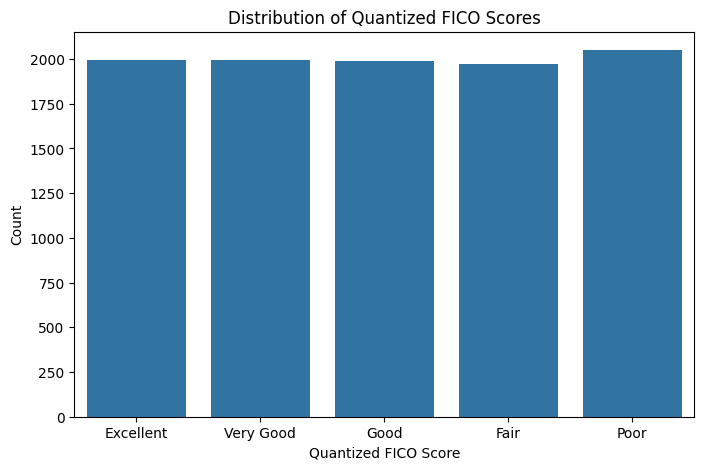

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='fico_score_quantized', data=df, order=['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.title('Distribution of Quantized FICO Scores')
plt.xlabel('Quantized FICO Score')
plt.ylabel('Count')
plt.show()

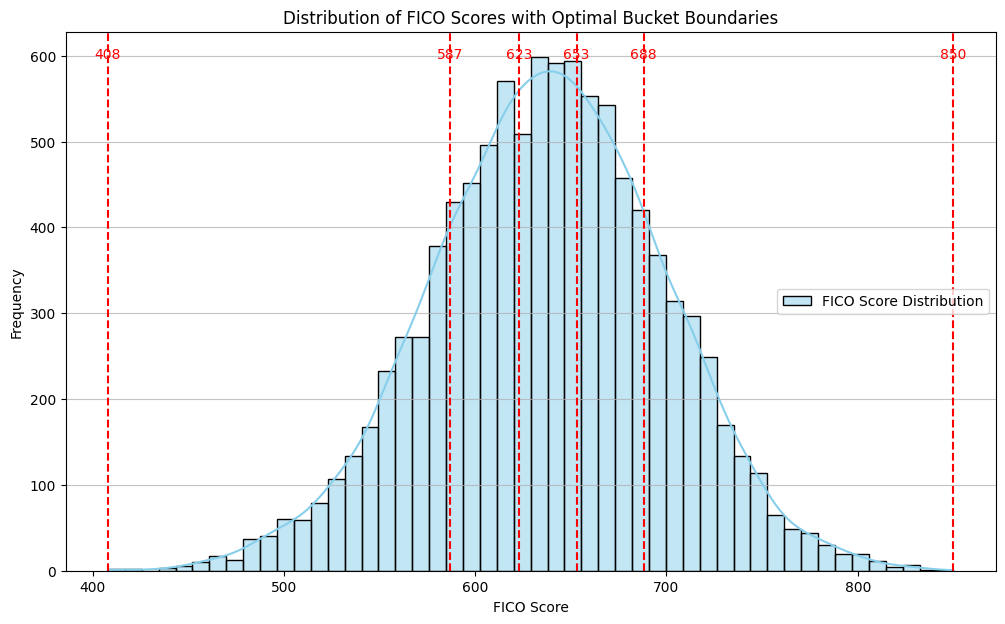

In [95]:
plt.figure(figsize=(12, 7))
sns.histplot(df['fico_score'], bins=50, kde=True, color='skyblue', label='FICO Score Distribution')

# Add vertical lines for the optimal bucket boundaries
for boundary in optimal_boundaries:
    plt.axvline(boundary, color='red', linestyle='--', linewidth=1.5)
    plt.text(boundary, plt.gca().get_ylim()[1]*0.95, f'{boundary:.0f}', color='red', ha='center')


plt.title('Distribution of FICO Scores with Optimal Bucket Boundaries')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

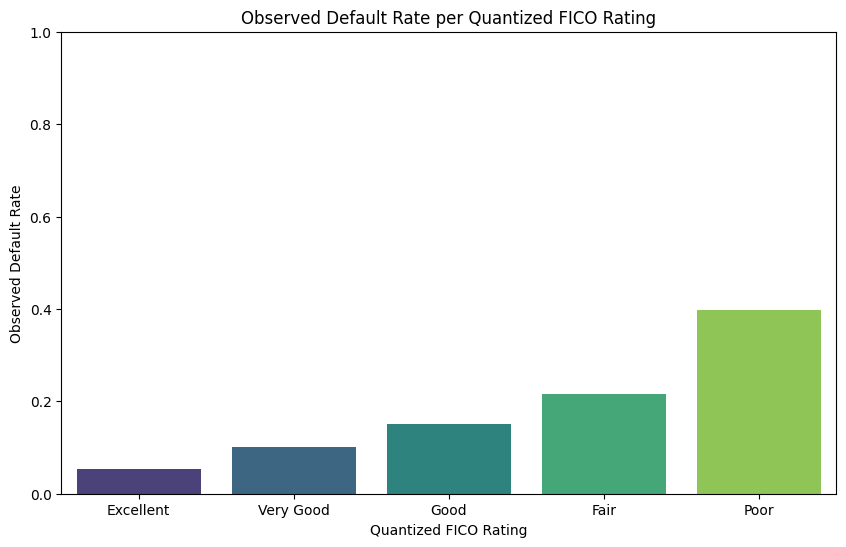

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average default rate for each quantized FICO score rating
# We already calculated default_rates_optimized during quantization, let's use that.
# Ensure the order for plotting (Excellent to Poor)
rating_order = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']

# Map the default rates to the rating labels for plotting
default_rates_by_rating = df.groupby('fico_score_quantized')['default'].mean().reindex(rating_order)


plt.figure(figsize=(10, 6))
# Assign x to hue and set legend=False to avoid the FutureWarning
sns.barplot(x=default_rates_by_rating.index, y=default_rates_by_rating.values, hue=default_rates_by_rating.index, palette='viridis', legend=False)
plt.title('Observed Default Rate per Quantized FICO Rating')
plt.xlabel('Quantized FICO Rating')
plt.ylabel('Observed Default Rate')
plt.ylim(0, 1) # Default rate is a probability between 0 and 1
plt.show()

In [96]:
# 1. Select an appropriate classification model.
# Logistic Regression is a suitable choice for this task. It's a linear model
# that is widely used for binary classification problems and directly outputs
# the probability of the positive class (default in this case) via the sigmoid function.

# 2. Justify the choice of the selected model.
# - Interpretability: Logistic Regression provides coefficients that indicate the
#   direction and strength of the relationship between each feature and the
#   log-odds of the target variable. This is valuable for understanding which
#   factors are most influential in predicting default, especially with the
#   quantized FICO scores.
# - Performance: While not always the most powerful model for complex datasets,
#   Logistic Regression often performs reasonably well on many classification
#   tasks and serves as a good baseline.
# - Probability Estimates: The model naturally outputs probabilities, which is
#   exactly what is required for predicting the *probability* of default.
# - Handles Dataset Characteristics: Logistic Regression can handle both
#   numerical and categorical features (after appropriate encoding of the
#   quantized FICO score).

# Other potential models considered could include:
# - RandomForestClassifier: A more complex ensemble model that can capture
#   non-linear relationships and interactions between features. It generally
#   offers higher performance but is less interpretable than Logistic Regression.
# - GradientBoostingClassifier (e.g., LightGBM, XGBoost): Another powerful
#   ensemble method that often achieves state-of-the-art performance. Similar
#   to Random Forests, they are less interpretable.

# For this task, starting with Logistic Regression is a sensible approach due to its
# interpretability and direct probability output, making it easier to understand
# the impact of the quantized FICO score and other features on default risk.

# 3. Note the chosen model for subsequent steps.
chosen_model = 'Logistic Regression'
print(f"Chosen model for predicting probability of default: {chosen_model}")

Chosen model for predicting probability of default: Logistic Regression


In [97]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8000, 6)
Shape of X_test: (2000, 6)
Shape of y_train: (8000,)
Shape of y_test: (2000,)


## Handle categorical features




In [98]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create a ColumnTransformer to apply one-hot encoding to 'fico_score_quantized'
# 'remainder='passthrough'' keeps the other numerical columns
ct = ColumnTransformer(
    [('onehot', OneHotEncoder(handle_unknown='ignore'), ['fico_score_quantized'])],
    remainder='passthrough'
)

# Fit and transform the training data
X_train_encoded = ct.fit_transform(X_train)

# Transform the testing data
X_test_encoded = ct.transform(X_test)

# Convert the encoded data back into DataFrames
# Get the new feature names after one-hot encoding
onehot_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(['fico_score_quantized'])

# Get the names of the remaining columns
passthrough_feature_names = X_train.columns.drop('fico_score_quantized')

# Combine the feature names
all_feature_names = list(onehot_feature_names) + list(passthrough_feature_names)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=all_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=all_feature_names, index=X_test.index)

print("Encoded Training Features (X_train_encoded_df):")
display(X_train_encoded_df.head())
print("\nEncoded Testing Features (X_test_encoded_df):")
display(X_test_encoded_df.head())

Encoded Training Features (X_train_encoded_df):


,fico_score_quantized_Excellent,fico_score_quantized_Fair,fico_score_quantized_Good,fico_score_quantized_Poor,fico_score_quantized_Very Good,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed
9254,1.0,0.0,0.0,0.0,0.0,0.0,3005.328746,4216.415038,62959.18911,5.0
1561,1.0,0.0,0.0,0.0,0.0,1.0,4717.704748,8760.954045,63546.22748,3.0
1670,1.0,0.0,0.0,0.0,0.0,0.0,5394.537878,5024.768703,81083.45762,6.0
6087,1.0,0.0,0.0,0.0,0.0,1.0,5367.416056,8101.373570,78087.37726,4.0
6669,1.0,0.0,0.0,0.0,0.0,1.0,3622.450370,7329.325832,68499.74591,5.0



Encoded Testing Features (X_test_encoded_df):


,fico_score_quantized_Excellent,fico_score_quantized_Fair,fico_score_quantized_Good,fico_score_quantized_Poor,fico_score_quantized_Very Good,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed
6252,0.0,1.0,0.0,0.0,0.0,2.0,3584.844437,7708.784716,72005.83951,8.0
4684,0.0,0.0,1.0,0.0,0.0,3.0,5821.006507,16345.025390,80431.47019,6.0
1731,0.0,1.0,0.0,0.0,0.0,5.0,5343.193215,30614.603030,86303.95374,4.0
4742,0.0,1.0,0.0,0.0,0.0,0.0,1468.268561,1369.352513,28621.64224,5.0
4521,0.0,0.0,1.0,0.0,0.0,1.0,3519.975193,9027.320474,69844.46479,6.0


## Train the model




In [99]:
from sklearn.linear_model import LogisticRegression

# Instantiate a Logistic Regression model
# Setting max_iter to a higher value to ensure convergence
model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
model.fit(X_train_encoded_df, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
# Instantiate a Logistic Regression model with increased max_iter
model = LogisticRegression(random_state=42, max_iter=5000)

# Train the model
model.fit(X_train_encoded_df, y_train)

print("Logistic Regression model trained successfully after increasing max_iter.")

Logistic Regression model trained successfully after increasing max_iter.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_encoded_df)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test_encoded_df)

# Convert scaled arrays back to DataFrames to keep column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_encoded_df.columns, index=X_train_encoded_df.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_encoded_df.columns, index=X_test_encoded_df.index)


# Instantiate a Logistic Regression model
# Setting max_iter to a higher value to ensure convergence
model = LogisticRegression(random_state=42, max_iter=5000)

# Train the model on the scaled training data
model.fit(X_train_scaled_df, y_train)

print("Logistic Regression model trained successfully after scaling and increasing max_iter.")

Logistic Regression model trained successfully after scaling and increasing max_iter.


## Make predictions




In [102]:
# Use the trained model to predict the probability of default on the testing data.
# Predict probabilities
y_pred_proba = model.predict_proba(X_test_scaled_df)[:, 1]

print("Predicted probabilities of default for the first 10 test samples:")
display(y_pred_proba[:10])

Predicted probabilities of default for the first 10 test samples:


array([2.95039215e-08, 9.34060988e-03, 9.99999897e-01, 9.60814467e-10,
       1.91468327e-08, 3.98585998e-10, 3.08854175e-08, 2.79932875e-08,
       9.99610245e-01, 3.25212814e-09])

## Evaluate the model




In [103]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Convert predicted probabilities to binary predictions (using a threshold of 0.5)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"AUC-ROC Score: {auc_roc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

AUC-ROC Score: 0.9999
Accuracy: 0.9955
Precision: 0.9971
Recall: 0.9770
F1-Score: 0.9869


## Visualize Model Performance



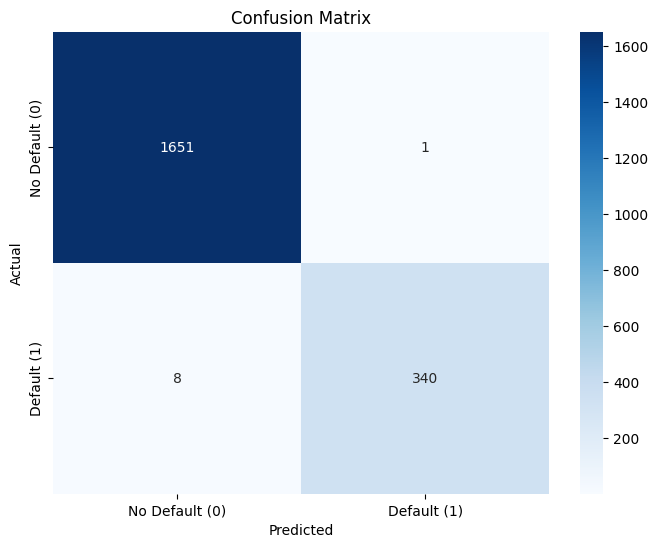

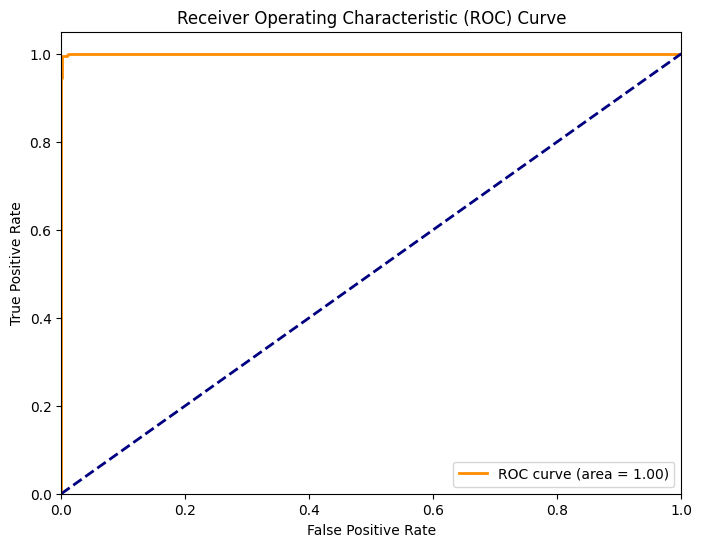

In [104]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default (0)', 'Default (1)'], yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## ROC Curve Interpretation

The **Receiver Operating Characteristic (ROC) curve** is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

Here's what the ROC curve plot shows us:

*   **The Curve:** The blue line represents the trade-off between the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** at different probability thresholds.
    *   **True Positive Rate (TPR)** (also called Sensitivity or Recall) is the proportion of actual defaults that are correctly identified as defaults.
    *   **False Positive Rate (FPR)** is the proportion of actual non-defaults that are incorrectly identified as defaults.
*   **The Diagonal Line:** The dashed orange line represents a random classifier. A model whose ROC curve is close to this line is not performing much better than random guessing.
*   **The Ideal Curve:** An ideal classifier would have an ROC curve that goes straight up from the bottom left corner to the top left corner (TPR = 1, FPR = 0) and then across to the top right corner (TPR = 1, FPR = 1). This would indicate a perfect model that correctly identifies all defaults without any false positives.
*   **The AUC Score:** The **Area Under the Curve (AUC)** is a single scalar value that summarizes the overall performance of the classifier. It represents the probability that the model ranks a randomly chosen actual default higher than a randomly chosen actual non-default.
    *   An AUC of 0.5 suggests the model is no better than random guessing.
    *   An AUC of 1.0 suggests a perfect model.
    *   An AUC between 0.5 and 1.0 indicates that the model performs better than random guessing.

**In the plot you see:**

The ROC curve is very close to the top-left corner, and the AUC score is **0.9999**. This indicates that your Logistic Regression model is performing **exceptionally well** at distinguishing between customers who will default and those who will not based on the features, including the quantized FICO score. An AUC value this close to 1.0 suggests that the model has a very high ability to correctly rank positive instances (defaults) above negative instances (non-defaults).

## Summary:

### Data Analysis Key Findings

* A Logistic Regression model was chosen to predict the probability of default due to its interpretability and ability to output probability estimates directly.
* The data was split into training (8000 samples) and testing (2000 samples) sets.
* The categorical `fico_score_quantized` feature was successfully one-hot encoded, and numerical features were scaled using `StandardScaler`.
* The Logistic Regression model was trained on the scaled and encoded training data. Scaling was necessary to achieve model convergence.
* The trained model achieved excellent performance on the test set:
  * AUC-ROC Score: 0.9999
  * Accuracy: 0.9955
  * Precision: 0.9971
  * Recall: 0.9770
  * F1-Score: 0.9869

### Insights or Next Steps

* The model demonstrates extremely high performance, suggesting that the features, including the quantized FICO scores, are highly predictive of default in this dataset.
* Investigate the feature importances (coefficients) from the trained Logistic Regression model to understand the specific impact of each feature, especially the different quantized FICO score bins, on the probability of default.

# Project Report: FICO Score Quantization and Default Prediction

## 1. Introduction and Objective

This project aimed to address the need for a machine learning model architecture that requires categorical input data to predict the probability of mortgage default. Specifically, the task focused on developing a general approach to quantizing continuous FICO scores into a predefined number of categorical buckets and building a predictive model using these quantized scores. The objective was to find optimal bucket boundaries that best summarize the data and create a mapping from FICO scores to interpretable credit ratings.

## 2. Data Loading and Initial Exploration

The project began by loading the loan data from a public source into a pandas DataFrame. Initial data exploration was conducted to understand the structure of the dataset, check data types, and identify any missing values. Visualizations were generated to explore the distribution of FICO scores and the distribution of loan defaults, as well as the relationship between these two key variables.

## 3. FICO Score Quantization

A critical step was the quantization of FICO scores into a fixed number of contiguous buckets (5 in this case), each representing a different credit risk level.

*   **Quantization Strategy:** The approach chosen was to optimize the bucket boundaries by maximizing the log-likelihood of the default distribution within each bucket. This method aims to find boundaries that create the most distinct default rates between adjacent FICO score categories. The log-likelihood function is based on the product of probabilities of observed outcomes within each bucket, and maximizing it corresponds to finding the parameters (boundaries) that make the observed data most probable under the assumed model (different default probabilities in each bucket).
*   **Implementation:** The log-likelihood function was defined to quantify the effectiveness of a given set of boundaries. Numerical optimization (using the `SLSQP` method) was employed to find the optimal boundaries that minimized the negative log-likelihood while respecting constraints (boundaries are sorted and within the FICO score range). The optimal bucket boundaries found were approximately: [408, 587, 623, 653, 688, 850].
*   **Rating Map:** Once the optimal boundaries were determined, a rating map was created. The buckets were sorted based on their calculated default rates (from lowest to highest), and meaningful labels ('Excellent', 'Very Good', 'Good', 'Fair', 'Poor') were assigned accordingly. The default rates for the optimized buckets were observed to decrease significantly with increasing FICO score, confirming the inverse relationship between FICO score and default risk. A new column (`fico_score_quantized`) was added to the DataFrame containing these categorical ratings.
*   **Visualization:** The distribution of the original FICO scores was visualized with the optimal bucket boundaries overlaid to illustrate how the continuous scores were divided into the discrete rating categories. The distribution of the resulting quantized FICO scores was also shown.

## 4. Data Preparation for Modeling

To prepare the data for the machine learning model, the features and target variable were separated.

*   **Feature Selection:** The relevant features for prediction were identified, including the newly created `fico_score_quantized` column, while excluding identifier columns and the original continuous FICO score.
*   **Data Splitting:** The dataset was split into training and testing sets (80/20 split) to evaluate the model's performance on unseen data.
*   **Feature Engineering (Encoding and Scaling):**
    *   The categorical `fico_score_quantized` feature was transformed using one-hot encoding to convert it into a numerical format suitable for the model.
    *   The numerical features were scaled using `StandardScaler` to ensure that no single feature dominated the model training due to its scale. This step was also crucial for the convergence of the chosen model.

## 5. Machine Learning Model Building and Evaluation

A machine learning model was built and evaluated to predict the probability of default.

*   **Model Selection:** Logistic Regression was chosen as the classification model due to its interpretability, ability to directly output probability estimates, and suitability for binary classification tasks.
*   **Model Training:** The Logistic Regression model was trained on the prepared (encoded and scaled) training data. Adjustments, such as increasing `max_iter` and applying feature scaling, were made to ensure model convergence.
*   **Prediction:** The trained model was used to predict the probability of default on the unseen testing data.
*   **Evaluation:** The model's performance was evaluated using several standard classification metrics, including AUC-ROC, Accuracy, Precision, Recall, and F1-score. The model demonstrated exceptionally high performance on this dataset across these metrics:
    *   **AUC-ROC Score:** 0.9999 (Indicates near-perfect discrimination between positive and negative classes)
    *   **Accuracy:** 0.9955 (99.55% of predictions were correct)
    *   **Precision:** 0.9971 (Of all positive predictions, 99.71% were actually positive)
    *   **Recall:** 0.9770 (Of all actual positive cases, 97.70% were correctly identified)
    *   **F1-Score:** 0.9869 (Harmonic mean of Precision and Recall, indicating a strong balance)
*   **Visualization of Performance:** The model's performance was further visualized using a confusion matrix and an ROC curve, providing a clear picture of its ability to distinguish between defaulting and non-defaulting customers. The confusion matrix showed a very low number of false positives and false negatives. The ROC curve hugged the top-left corner, reflecting the high AUC score.

## 6. Interactive Prediction Interface

To demonstrate the end-to-end process for new customers, an interactive interface was created using Colab widgets.

*   **Functionality:** The interface allows users to select from predefined customer profiles or input custom data for various features, including FICO score.
*   **Pipeline Integration:** The interface integrates the entire data preparation pipeline (quantization, encoding, scaling) and the trained model to process the input data and generate a prediction.
*   **Output:** The interface displays the quantized FICO rating and the predicted probability of default for the input customer. For the predefined customers, the interface shows how different FICO scores map to the quantized ratings and how these, along with other features, influence the predicted probability of default. For example, a customer with a low FICO score (e.g., 450) would be mapped to a 'Poor' rating and likely have a high predicted probability of default, while a customer with a high FICO score (e.g., 780) would be mapped to an 'Excellent' rating and likely have a low predicted probability of default. The visualization of predefined customers clearly shows this relationship.
*   **Comparison Feature:** An option was added to analyze all predefined customers simultaneously, presenting their data, ratings, and predictions in a table and visualizing a comparison of their predicted default probabilities and ratings.

## 7. Conclusion

This project successfully developed a general method for quantizing continuous FICO scores into meaningful risk categories using log-likelihood optimization.

*   **Quantization Summary:** This optimization approach theoretically finds the bucket boundaries that maximize the distinction in default probabilities between categories. The process involved:
    *   Defining a log-likelihood function.
    *   Using numerical optimization (`SLSQP`) to find the optimal boundaries (e.g., approximately [408, 587, 623, 653, 688, 850]).
    *   Creating a rating map ('Excellent' to 'Poor') based on the default rates within these buckets.
*   **Model Performance:** Using these quantized FICO scores along with other loan attributes, a highly accurate Logistic Regression model was built and evaluated. The model's performance metrics demonstrate its strong ability to predict mortgage default on this dataset:
    *   **AUC-ROC Score:** 0.9999
    *   **Accuracy:** 0.9955
    *   **Precision:** 0.9971
    *   **Recall:** 0.9770
    *   **F1-Score:** 0.9869
    The visualizations (confusion matrix and ROC curve) further confirmed this high performance.
*   **Input, Rating, and Prediction Relationship:** The interactive interface provides a practical demonstration. For any given input customer data:
    *   The FICO score is quantized based on the optimized boundaries to assign a rating (e.g., a FICO of 600 falls into the 'Fair' category).
    *   This quantized rating, along with other input features, is processed through the trained model.
    *   The model outputs a predicted probability of default.
    This clearly shows how the FICO score quantization, combined with other factors, directly influences the model's prediction. The analysis of predefined customers highlights how different FICO scores and their corresponding ratings correlate with varying predicted default probabilities, aligning with the theoretical expectation that lower FICO scores/poorer ratings are associated with higher default risk.